<a href="https://colab.research.google.com/github/CarysDT/Colab-Notebook/blob/main/Unit7/Unit7Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-cj6ge07r
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-cj6ge07r
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev22+g0184702f-py3-none-any.whl size=1262235 sha256=f26d3f28b61c00c0ebc5792410e6270d10fec88d6915038620cea43f2a13fb12
  Stored in directory: /tmp/pip-ephem-wheel-cache-trkaxuwk/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 1.4 MB/s eta 0:00:00
   ━

In [71]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb
import seaborn as sns

In [36]:
players = pd.read_csv('https://raw.githubusercontent.com/CarysDT/Colab-Notebook/refs/heads/main/Player%20Yards%20-%20Sheet1%20(2).csv')

# Getting the data I want

In [39]:
df = pd.DataFrame(players)
# Filter to keep only players where "Games Played" is greater than zero
filtered_dfa = df[df['GP'] > 0]
# Only have players that would contribute majorly to offensive yards
desired_positions = ['WR', 'TE', 'RB']
filtered_dfb = df[df['Pos'].isin(desired_positions)]

In [41]:
# Function to convert ft-in to inches
def convert_to_inches(height_str):
    feet, inches = height_str.split('-')
    return int(feet) * 12 + int(inches)
filtered_dfb['Hii'] = filtered_dfb['Height'].apply(convert_to_inches)

# Display the updated DataFrame
print(filtered_dfb)

                   Player   Age Pos  GP  GS  Weight Height    OYA  AYD  Hii
0          Israel Abanika  22.0  RB   0   0     216   5-11  376.3    0   71
1           Brandon Aiyuk  26.0  WR   7   7     200    6-0  376.3  374   72
16           Chris Conley  32.0  WR  15   2     205    6-3  376.3   76   75
17           Jacob Cowing  23.0  WR  15   0     171    5-9  376.3  245   69
30         Isaac Guerendo  24.0  RB  16   3     221    6-0  376.3  420   72
...                   ...   ...  ..  ..  ..     ...    ...    ...  ...  ...
997         Jamari Thrash  24.0  WR   9   0     190    6-0  300.8   22   72
998        Cedric Tillman  24.0  WR  11   6     215    6-3  300.8  339   75
1003     Blake Whiteheart  24.0  TE  11   2     247    6-4  300.8   51   76
1006     Michael Woods II  24.0  WR   5   2     204    6-1  300.8   65   73
1018  Tre' McKitty (FRES)  25.0  TE   0   0     246    6-4  300.8  117   76

[258 rows x 10 columns]


<ipython-input-41-cedcee04f641>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dfb['Hii'] = filtered_dfb['Height'].apply(convert_to_inches)


# Basic Comparison

In [50]:
model = bmb.Model("OYA ~ Pos", filtered_dfb, family="negativebinomial")
idata = model.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


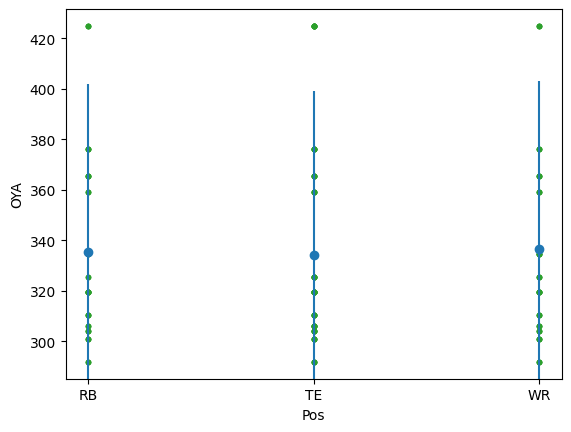

In [51]:
bmb.interpret.plot_predictions(model, idata, "Pos", pps=True)
plt.plot(filtered_dfb.Pos, filtered_dfb.OYA, "C2.", zorder=-3)

# Error 1

<ipython-input-24-0991a9cca358>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dfb['Pos'] = filtered_dfb['Pos'].astype('category')


Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


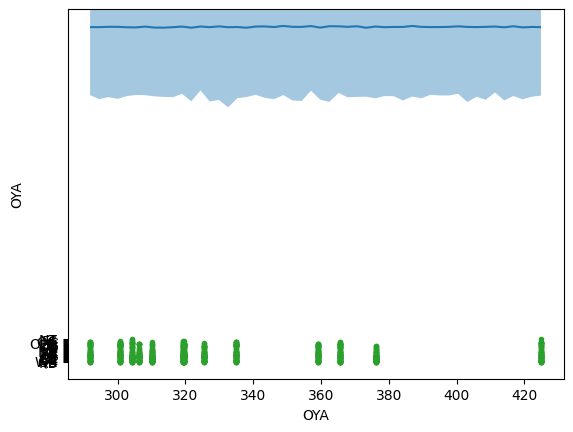

In [24]:
# Convert categorical variable 'Position' into a pandas Categorical type for Bambi
filtered_dfb['Pos'] = filtered_dfb['Pos'].astype('category')

# Specify the formula for Bayesian regression
formula = 'OYA ~ Pos'

# Set up the model with Bambi
model = bmb.Model(formula, data=filtered_dfb)

# Fit the model using MCMC sampling
idata = model.fit(draws=2000, tune=1000)

bmb.interpret.plot_predictions(model, idata, "OYA", pps=True)
#raw data
plt.plot(players.OYA, players.Pos, "C2.", zorder=-3)

# B Spline

In [53]:
model_a = bmb.Model("AYD ~ GP + Hii + Weight + Pos + OYA", filtered_dfb, family="negativebinomial")
idata_a = model_a.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


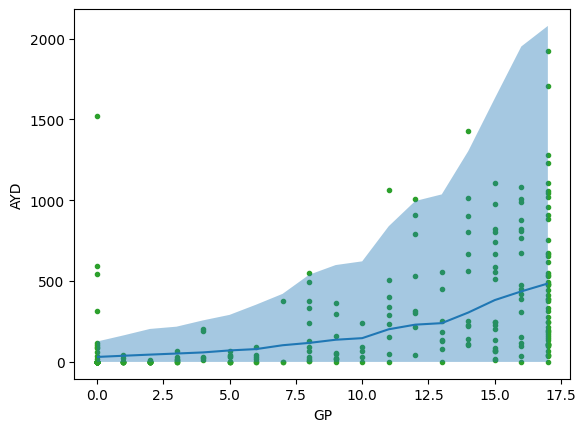

In [54]:
bmb.interpret.plot_predictions(model_a, idata_a, ["GP"], pps=True)
plt.plot(filtered_dfb.GP, filtered_dfb.AYD, "C2.", zorder=-3)

In [85]:
az.loo(idata_a)

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,0
elpd_loo,-1437.69024
se,48.027382
p_loo,10.746956
n_samples,2000
n_data_points,258
warning,True
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,log
good_k,0.697064


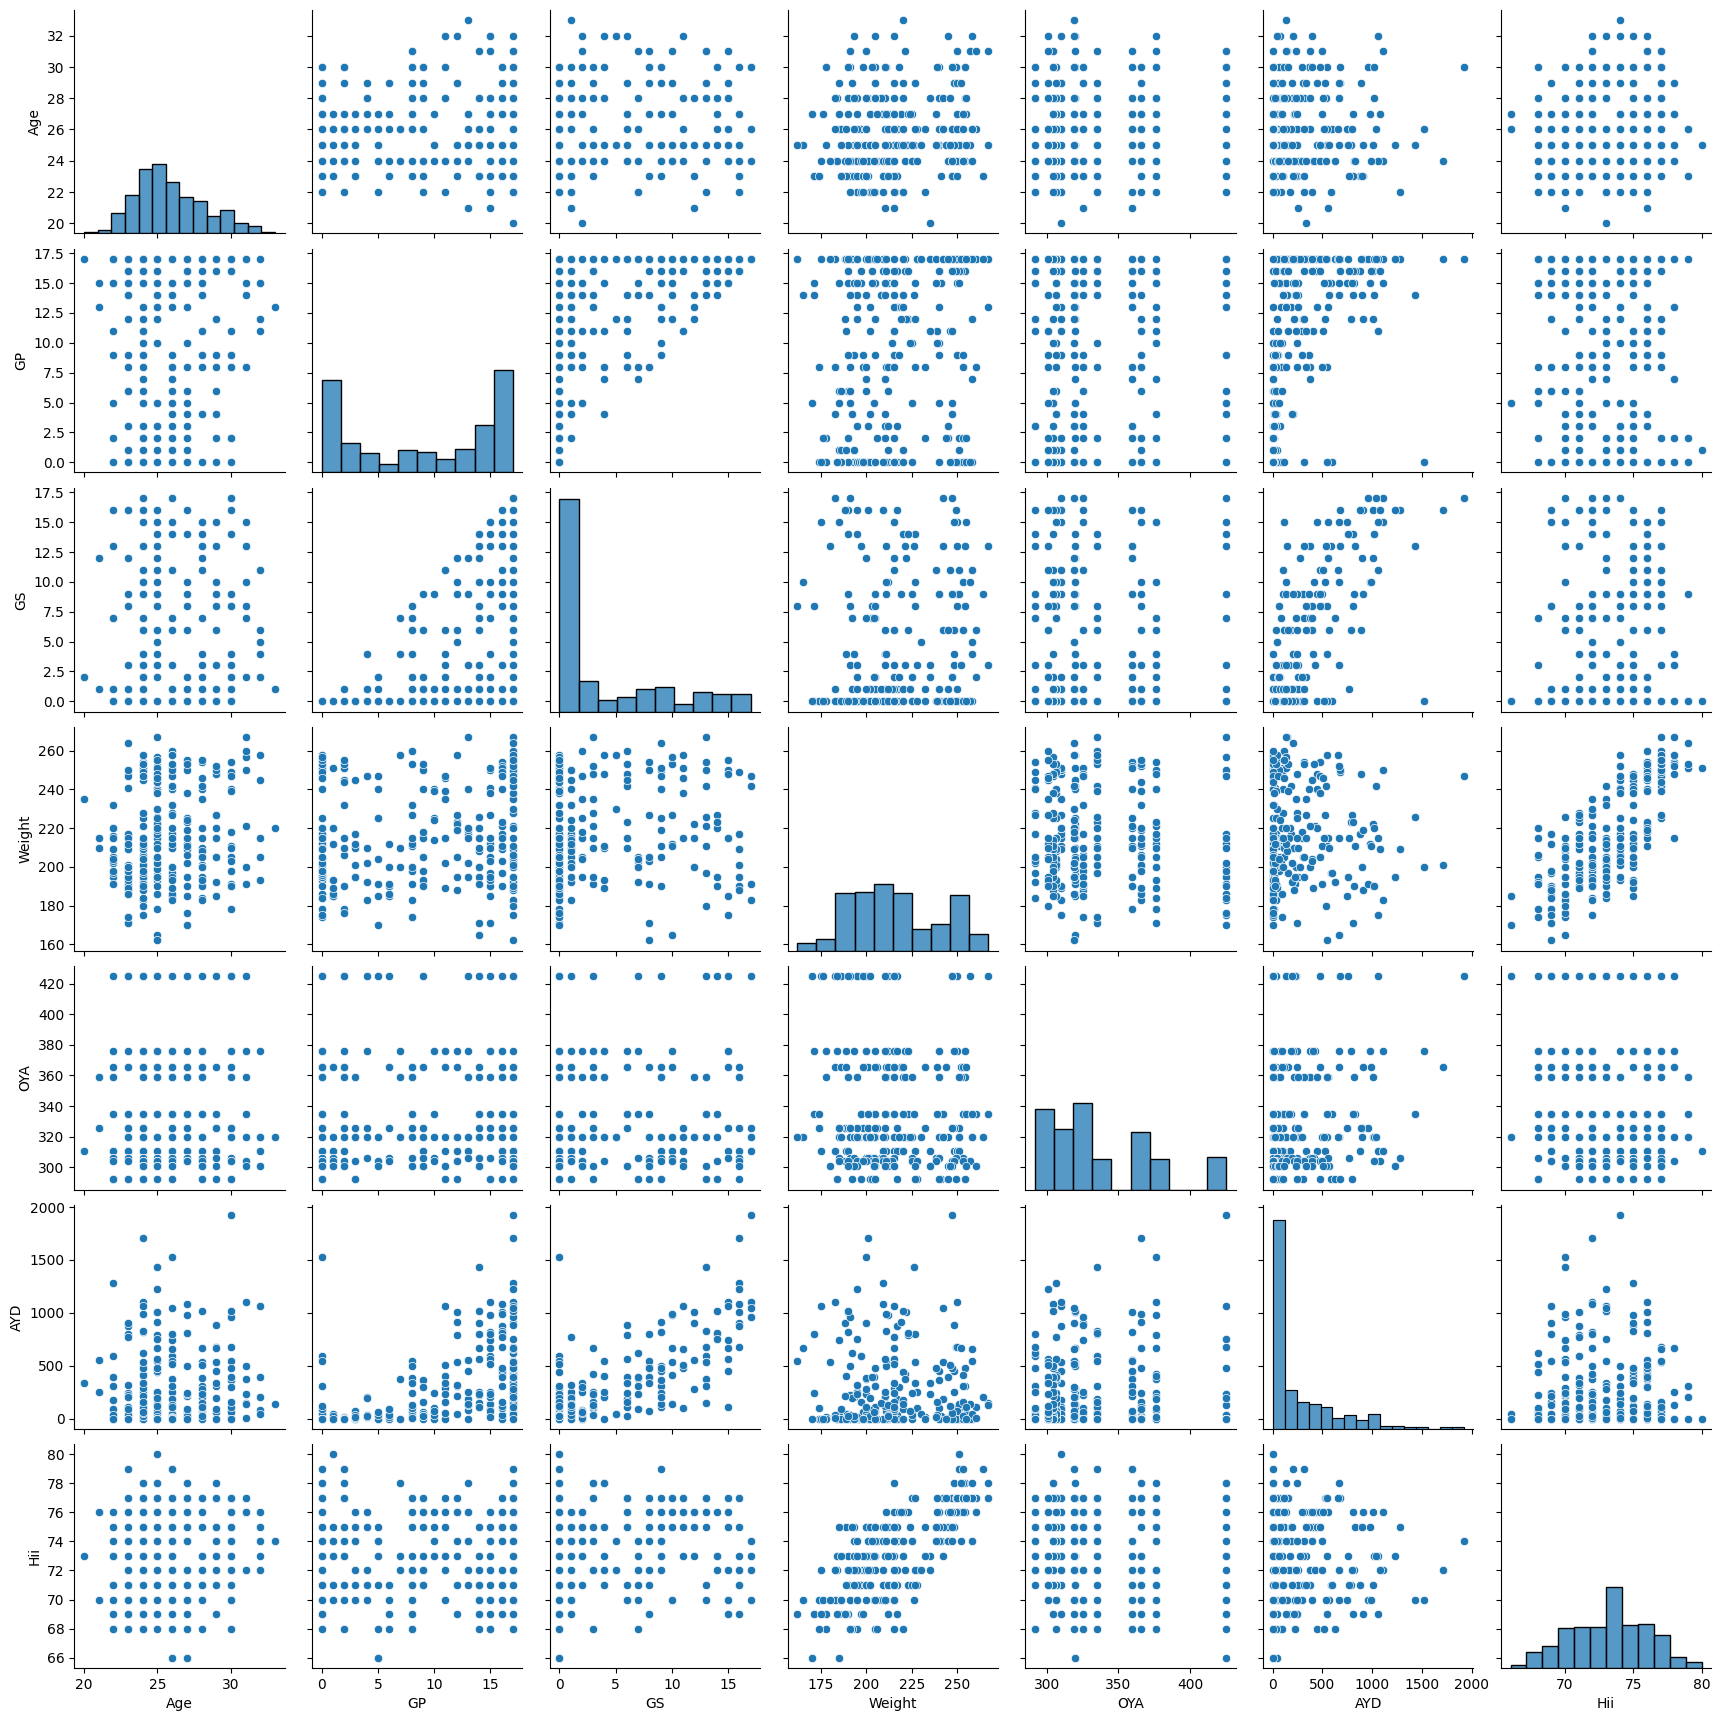

In [72]:
sns.pairplot(filtered_dfb)

In [79]:
print(filtered_dfb.describe())

              Age          GP          GS      Weight         OYA  \
count  257.000000  258.000000  258.000000  258.000000  258.000000   
mean    25.828794    9.069767    3.996124  215.368217  335.277907   
std      2.531417    6.726087    5.348914   24.234588   37.194609   
min     20.000000    0.000000    0.000000  162.000000  291.900000   
25%     24.000000    2.000000    0.000000  197.000000  306.200000   
50%     25.000000   10.000000    1.000000  211.000000  319.700000   
75%     27.000000   16.000000    8.000000  238.750000  363.900000   
max     33.000000   17.000000   17.000000  267.000000  424.900000   

               AYD         Hii  
count   258.000000  258.000000  
mean    261.170543   73.096899  
std     359.426903    2.849382  
min       0.000000   66.000000  
25%       0.000000   71.000000  
50%      95.000000   73.000000  
75%     397.500000   75.000000  
max    1921.000000   80.000000  


In [76]:
num_knots = 6
knots3 = np.linspace(1, 17, num_knots+2)[1:-1]
knots4 = np.linspace(291.9, 424.9, num_knots+2)[1:-1]

In [81]:
knots3 = np.quantile(filtered_dfb["GP"], [0.25, 0.5, 0.75])
knots4 = np.quantile(filtered_dfb["OYA"], [0.25, 0.5, 0.75])

In [82]:
model_b = bmb.Model("AYD ~ Hii + Weight + bs(GP, degree=3, knots=knots3) + bs(OYA, degree=3, knots=knots4) + Pos", filtered_dfb, family="negativebinomial")

In [80]:
print(knots3, knots4)

[ 3.28571429  5.57142857  7.85714286 10.14285714 12.42857143 14.71428571] [310.9 329.9 348.9 367.9 386.9 405.9]


In [83]:
idata_b = model_b.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


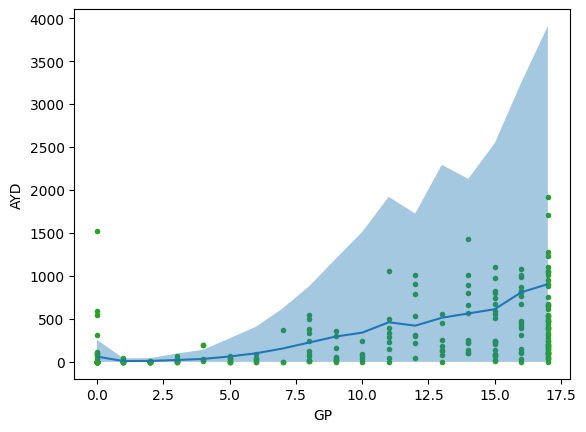

In [84]:
bmb.interpret.plot_predictions(model_b, idata_b, ["GP"], pps=True)
plt.plot(filtered_dfb.GP, filtered_dfb.AYD, "C2.", zorder=-3)

In [89]:
az.loo(idata_b)

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,0
elpd_loo,-1433.633181
se,47.544693
p_loo,17.077939
n_samples,2000
n_data_points,258
warning,True
loo_i,[<xarray.DataArray 'loo_i' ()> Size: 8B\narray...
pareto_k,[<xarray.DataArray 'pareto_shape' ()> Size: 8B...
scale,log
good_k,0.697064


# Weird failure stuff

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


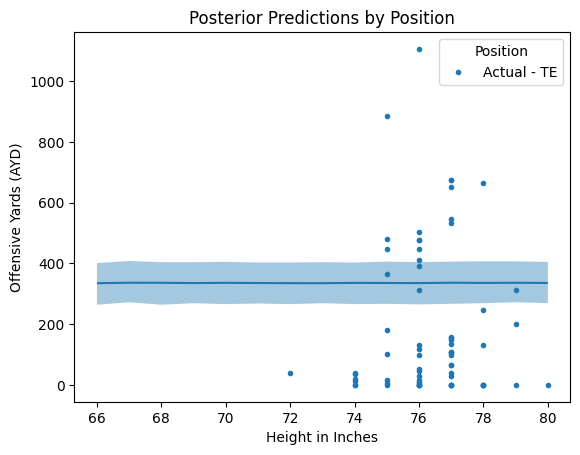

In [46]:
#plot posterior predictions
bmb.interpret.plot_predictions(model_spline, trace, "Height_in_inches", pps=True)
plt.plot(position_data.Height_in_inches, position_data['AYD'], ".", label=f'Actual - {pos}', zorder=-3)
# Set labels and title
plt.xlabel('Height in Inches')
plt.ylabel('Offensive Yards (AYD)')
plt.title('Posterior Predictions by Position')
plt.legend(title='Position')

# Show the plot
plt.show()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


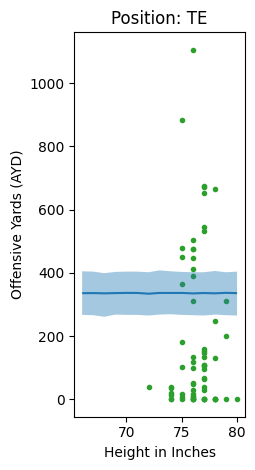

In [65]:
#lets try and split this up by position
positions_of_interest = ['TE']
# Loop through each position of interest (WR, RB, TE)
for idx, pos in enumerate(positions_of_interest):
    # Filter the dataset for the current position
    position_data = filtered_df[filtered_df['Pos'] == pos]
    model_spline = bmb.Model(formula, filtered_df, family="negativebinomial")
trace = model_spline.fit(draws=2000, tune=1000)
# Plot posterior predictions for the current position
ax = plt.subplot(1, 3, idx + 1)
bmb.interpret.plot_predictions(model_spline, trace, "Height_in_inches", pps=True, ax=ax)
ax.plot(position_data.Height_in_inches, position_data['AYD'], "C2.", zorder=-3)
# Add title and labels for each subplot
ax.set_title(f'Position: {pos}')
ax.set_xlabel('Height in Inches')
ax.set_ylabel('Offensive Yards (AYD)')
# Show the plot
plt.tight_layout()
plt.show()

This is a very bad predictor and does not follow any trends

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


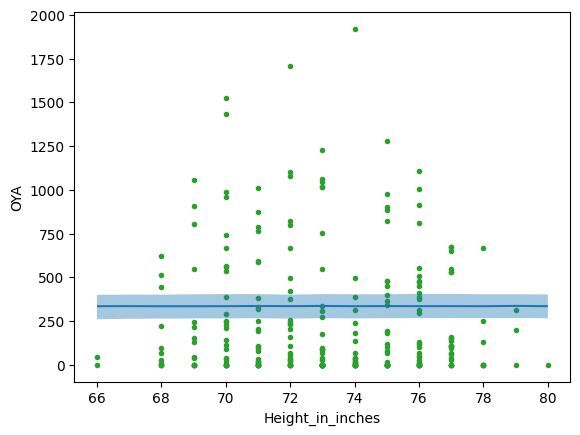

In [18]:
model_spline = bmb.Model(formula, filtered_df, family="negativebinomial")
trace = model_spline.fit(draws=2000, tune=1000)
# Plot the posterior predictions of the model
bmb.interpret.plot_predictions(model_spline, trace, "Height_in_inches", pps=True)

plt.plot(filtered_df.Height_in_inches, filtered_df['AYD'], "C2.", zorder=-3)

# Show the plot
plt.show()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


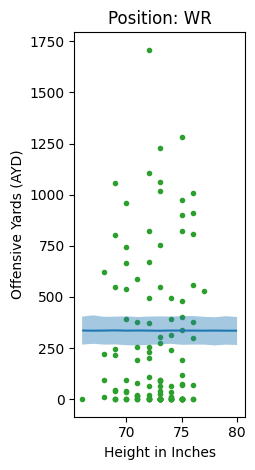

In [64]:
#lets try and split this up by position
positions_of_interest = ['WR']
# Loop through each position of interest (WR, RB, TE)
for idx, pos in enumerate(positions_of_interest):
    # Filter the dataset for the current position
    position_data = filtered_df[filtered_df['Pos'] == pos]
    model_spline = bmb.Model(formula, filtered_df, family="negativebinomial")
trace = model_spline.fit(draws=2000, tune=1000)
# Plot posterior predictions for the current position
ax = plt.subplot(1, 3, idx + 1)
bmb.interpret.plot_predictions(model_spline, trace, "Height_in_inches", pps=True, ax=ax)
ax.plot(position_data.Height_in_inches, position_data['AYD'], "C2.", zorder=-3)
# Add title and labels for each subplot
ax.set_title(f'Position: {pos}')
ax.set_xlabel('Height in Inches')
ax.set_ylabel('Offensive Yards (AYD)')
# Show the plot
plt.tight_layout()
plt.show()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
<ipython-input-66-85be04c1dc44>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Position')


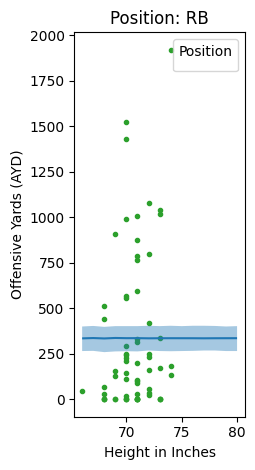

In [66]:
#lets try and split this up by position
positions_of_interest = ['RB']
# Loop through each position of interest (WR, RB, TE)
for idx, pos in enumerate(positions_of_interest):
    # Filter the dataset for the current position
    position_data = filtered_df[filtered_df['Pos'] == pos]
    model_spline = bmb.Model(formula, filtered_df, family="negativebinomial")
trace = model_spline.fit(draws=2000, tune=1000)
# Plot posterior predictions for the current position
ax = plt.subplot(1, 3, idx + 1)
bmb.interpret.plot_predictions(model_spline, trace, "Height_in_inches", pps=True, ax=ax)
ax.plot(position_data.Height_in_inches, position_data['AYD'], "C2.", zorder=-3)
# Add title and labels for each subplot
ax.set_title(f'Position: {pos}')
ax.set_xlabel('Height in Inches')
ax.set_ylabel('Offensive Yards (AYD)')
plt.legend(title='Position')
# Show the plot
plt.tight_layout()
plt.show()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


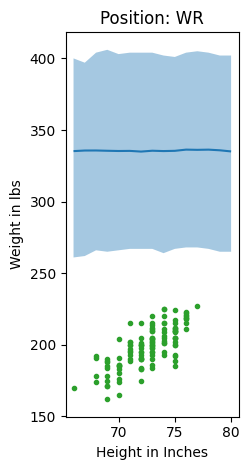

In [67]:
#lets try and split this up by position
positions_of_interest = ['WR']

# Loop through each position of interest (WR, RB, TE)
for idx, pos in enumerate(positions_of_interest):
    # Filter the dataset for the current position
    position_data = filtered_df[filtered_df['Pos'] == pos]
    model_spline = bmb.Model(formula, filtered_df, family="negativebinomial")
trace = model_spline.fit(draws=2000, tune=1000)
# Plot posterior predictions for the current position
ax = plt.subplot(1, 3, idx + 1)
bmb.interpret.plot_predictions(model_spline, trace, "Height_in_inches", pps=True, ax=ax)
ax.plot(position_data.Height_in_inches, position_data['Weight'], "C2.", zorder=-3)
# Add title and labels for each subplot
ax.set_title(f'Position: {pos}')
ax.set_xlabel('Height in Inches')
ax.set_ylabel('Weight in lbs')
# Show the plot
plt.tight_layout()
plt.show()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


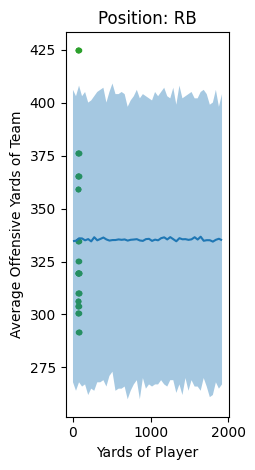

In [70]:
#lets try and split this up by position
positions_of_interest = ['RB']

# Loop through each position of interest (WR, RB, TE)
for idx, pos in enumerate(positions_of_interest):
    # Filter the dataset for the current position
    position_data = filtered_df[filtered_df['Pos'] == pos]
    model_spline = bmb.Model(formula, filtered_df, family="negativebinomial")
trace = model_spline.fit(draws=2000, tune=1000)
# Plot posterior predictions for the current position
ax = plt.subplot(1, 3, idx + 1)
bmb.interpret.plot_predictions(model_spline, trace, "AYD", pps=True, ax=ax)
ax.plot(position_data.Height_in_inches, position_data['OYA'], "C2.", zorder=-3)
# Add title and labels for each subplot
ax.set_title(f'Position: {pos}')
ax.set_xlabel('Yards of Player')
ax.set_ylabel('Average Offensive Yards of Team')
# Show the plot
plt.tight_layout()
plt.show()

# Trying different model

In [87]:
model_a = bmb.Model("AYD ~ Pos", filtered_dfb, family="negativebinomial")
idata_a = model_a.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


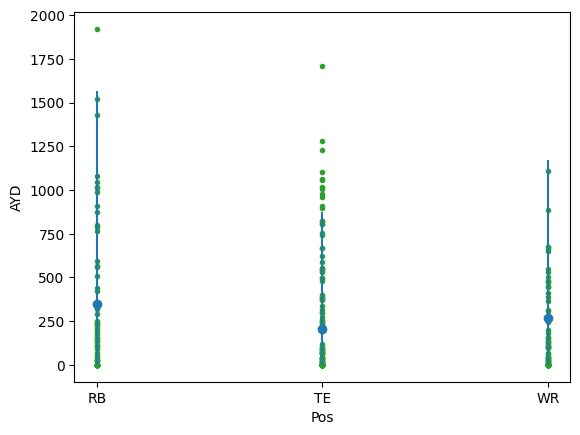

In [88]:
bmb.interpret.plot_predictions(model_a, idata_a, ["Pos"], pps=True)
plt.plot(filtered_dfb.Pos, filtered_dfb.AYD, "C2.", zorder=-3)

In [92]:
knots1 = np.quantile(filtered_dfb["AYD"], [0.25, 0.5, 0.75])

In [98]:
model_c = bmb.Model("bs(AYD, degree=3, knots=knots1) ~ Pos", filtered_dfb, family="negativebinomial")

In [100]:
idata_c = model_c.fit(idata_kwargs={"log_likelihood":True})

ValueError: Incompatible Elemwise input shapes [(258, 6), (1, 258)]

# Unit 7 Project: Polynomials, Splines, and GPs, Oh my!

**Task**:

Two parts:

1. Propose a data set that's compatible with pymc and/or bambi. I must approve your submission before you move on to part 2.

2. Create, analyze, and present any guassian process or approximate GP, degenerate or otherwise (this means glms and b splines are allowed), using pymc within the colab environment, on a data set of your choice, with the following conditions:
  - your final model must have more than 2 predictors. The intercept term doesn't count as a predictor here (even though technically it is), or if must be an actual GP
  - You must document and explain your model selection method. This means you must argue that your model choice (glm, b spline, GP) is better than at least one other choice. You may use either a theoretical or numerical argument.



Guidlines:

- Your data or your model type must be different from any project you've previously done.

- You are allowed to copy and paste any code from the notes, including my answer key (AK), without any reference or citations. Same goes for the course textbook, BAP3.

- This is an individual project. It is fine if you model the same process as a peer, but your raw data **must** be substantially different. "Substantially different" means that I, your instructor, arbitrarily think your data sets are different enough.

- Do not look at other student's code/jupyter notebooks. Copying, or copying and pasting, other students code will result in a failing grade. Also, I will tell all the other teachers I know that you cheated.

- If you want to know what another student did, ask them--any verbal communication about a project is allowed and encouraged. If you want to see a graphic they made, ask them to sketch a picture of it for you by hand.

- Any handwritten communication is also allowed and encouraged, so long as all parties are in the same physical location together. Example: you may sketch out a piece of code while verbally explaining to someone what you did. Do NOT: hand write the code for your entire project, take a picture, and send it to everyone in the course.

- If you use someone's code from outside this course (like from the internet, an AI, or your parent), you must ask me if it is ok, and you must cite them in your work. I don't care all they did was to click your space bar one more time: you tell me, and you cite their contribution. You don't need to tell me about or cite verbal or handwritten communication though.

- You may use a more complicated model--like something from further along in the course--IF I give you permission.

- If you are unsure whether or not something is ok or allowed: ASK BEFORE YOU DO IT.

Faliure to adhere to these guidlines will result in a failing grade.

Tips:

- Try to pick something that you care about, have knowledge of, experience with, or that you find interesting/cool.

- Gather data *before* picking a model or likelihood.

-  Use your best idea now; maybe you can look at the context you used in the previous project, and gather different data from it.

- Choose a data set with lots of columns, and lots of potential interactions between variables. It'll be more fun, and will make model/variable selection more relevant.

- This is not a competition to come up with the fanciest model structure. Find a data set that interests you, and apply the simplest model that captures the patterns in the data.

- Comment heavily, and explain your steps and thought process with text blocks. This is not only requried, it'll also help you understand what you're doing and what you want to do.

- I actually encourge you to use b splines; they work quite well, and trying to determine the location of the knots requires careful thought about the context of the data.

- Its ok to pick a data set for which you don't qute understand the context--so long as you think the context is cool.
